In [1]:
import sys
sys.path.append("..")

# Week of November 24

Last week i got distracted by the "VLF Hump." MM let me know to be cautious of creating papers for the "journal of who cares." I am going to refocus by going back to proper spectral analysis. 

**Analysis goals for the week**

- Plot a spectrogram with time on x axis and frequency on y axis
- have script for complex demodlation
- attempy wavelet analysis
- recreate figures from JB's draft

**Organizational Goals**
- organize github repo with level 0, level 1, level 2 scripts. Maybe ask for advice on best practices for creating these scripts. Like should I be sing dataframes for the scripts or should i stick to numpy arrays so I dont need to put everything in dataframes if I dont want to? or maybe i can hard code that in idk. 
- digest pequignets paper
- have "story" ready for meeting with JB

In [ ]:
import pandas as pd
from src.spectra import sensor_spectra

# ---- load data ----- #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

#--- compute 6 hour spectral averages (following JB's writeup)---#
from src.spectra import sensor_spectra

nperseg= 3600 /2 # 30 min at 1hz intervals


S1 = sensor_spectra(df1, nperseg=nperseg)
S6 = sensor_spectra(df6, nperseg=nperseg)

#### spectrogram analysis

- general spectrogram
- daily avg
- zoom in on SS and IG band (and VLF)?

In [ ]:
import numpy as np
TMAX = np.datetime64("2008-01-17")

# slice datasets before tmax 
S1t = S1.where(S1.time < TMAX, drop=True)
S6t = S6.where(S6.time < TMAX, drop=True)

NameError: name 'S1p' is not defined

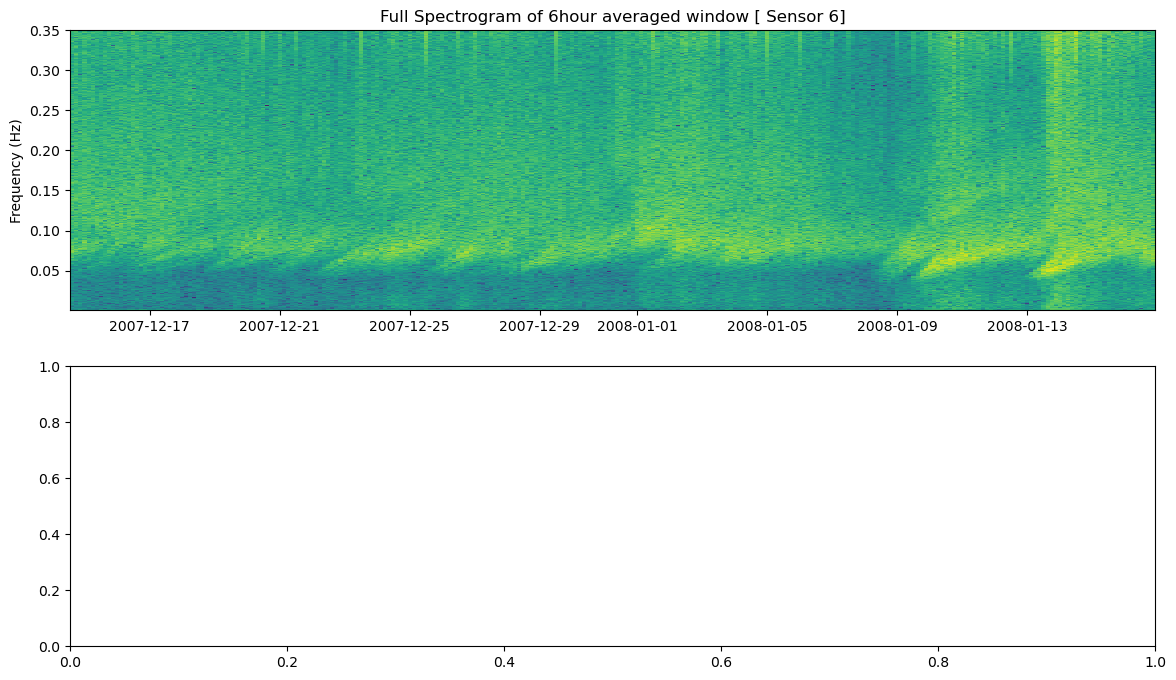

In [11]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt

S6p = S6t.sel(frequency=slice(0.0004, 0.35))  

fig, ax = plt.subplots(2,1,figsize=(14,8))

m0 = ax[0].pcolormesh(
    S6p["time"],
    S6p['frequency'],
    S6p["Seta"],
    shading="auto",
    cmap="viridis",
    norm=colors.LogNorm(),
)
ax[0].set_ylabel("Frequency (Hz)")
ax[0].set_title('Full Spectrogram of 6hour averaged window [ Sensor 6]')

m1 = ax[1].pcolormesh(
    S1p["time"],
    S1p['frequency'],
    S1p["Seta"],
    shading="auto",
    cmap="viridis",
    norm=colors.LogNorm(vmin=vmin, vmax=vmax),
)
ax[1].set_ylabel("Frequency (Hz)")
ax[1].set_title('Full Spectrogram of 6hour averaged window [ Sensor 1]')

plt.tight_layout()
cbar = fig.colorbar(m, ax=ax, label="Seta (m^2/Hz)")
plt.show()

In [9]:

import matplotlib.pyplot as plt
import matplotlib.colors as colors

daily6 = S6p.resample(time='1D').mean()
daily1 = S1p.resample(time='1D').mean()

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# --- TOP: Sensor 6 ---
daily6["Seta"].plot.pcolormesh(
    ax=axes[0],
    x="time",
    y="frequency",
    norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    cmap="viridis",
    add_colorbar=False,   
)
axes[0].set_title("Sensor 6 Daily Seta")
axes[0].set_ylabel("Frequency (Hz)")

# --- BOTTOM: Sensor 1 ---
daily1["Seta"].plot.pcolormesh(
    ax=axes[1],
    x="time",
    y="frequency",
    norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    cmap="viridis",
    add_colorbar=False,
)
axes[1].set_title("Sensor 1 Daily Seta")
axes[1].set_ylabel("Frequency (Hz)")
axes[1].set_xlabel("Time")

fig.tight_layout()

# Colorbar for entire figure
cbar = fig.colorbar(
    axes[0].collections[0],
    ax=axes,
    label="Seta (m²/Hz)"
)

plt.show()


NameError: name 'S1p' is not defined

Very cool. I'm noticing the dispersive properties of the offshore waves... clearly DW waves :)

Going to now narrow in on the IG band

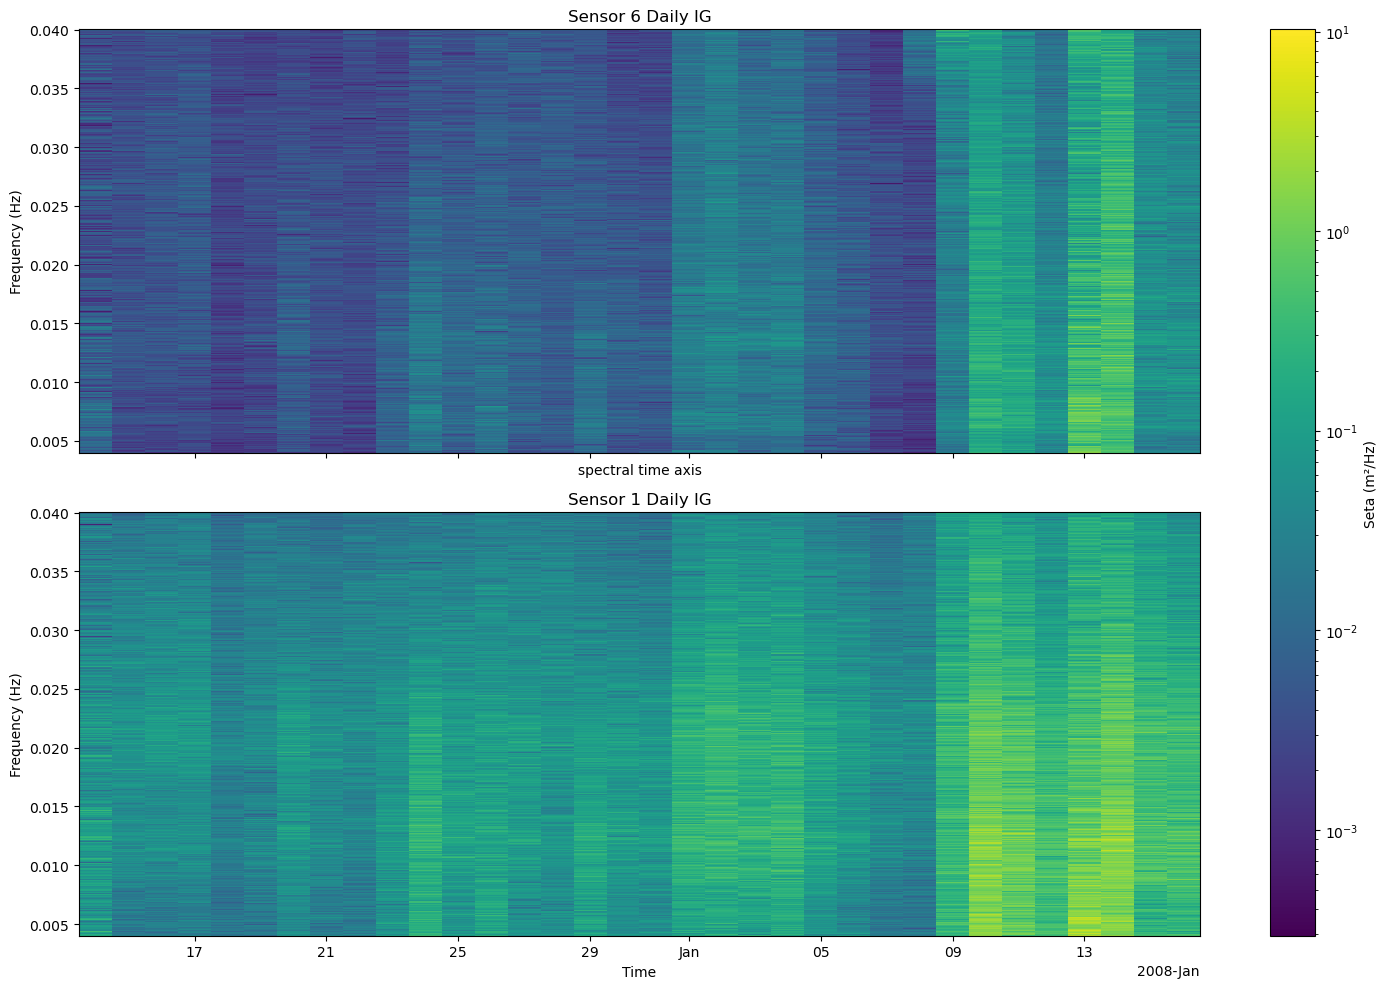

In [ ]:
IG6 = daily6.sel(frequency=slice(0.004, 0.04))
IG1 = daily1.sel(frequency=slice(0.004, 0.04))


fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# --- TOP: Sensor 6 ---
IG6["Seta"].plot.pcolormesh(
    ax=axes[0],
    x="time",
    y="frequency",
    norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    cmap="viridis",
    add_colorbar=False,   
)
axes[0].set_title("Sensor 6 Daily IG")
axes[0].set_ylabel("Frequency (Hz)")

# --- BOTTOM: Sensor 1 ---
IG1["Seta"].plot.pcolormesh(
    ax=axes[1],
    x="time",
    y="frequency",
    norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    cmap="viridis",
    add_colorbar=False,
)
axes[1].set_title("Sensor 1 Daily IG")
axes[1].set_ylabel("Frequency (Hz)")
axes[1].set_xlabel("Time")

fig.tight_layout()

# Colorbar for entire figure
cbar = fig.colorbar(
    axes[0].collections[0],
    ax=axes,
    label="Seta (m²/Hz)"
)

plt.show()


#### Complex Demodulation

Goal: extract the slowly varying envelope from the SS band, compare it to the IG band time series

**Steps**
1. select day -> find peak ss, $f_0$
2. complex demod over $f_0$
3. extract slowly varying envelope $A(t)$
4. Compute IG band time series
5. compare IG and A(t)

In [9]:
import numpy as np
import pandas as pd
from scipy.signal import spectrogram, butter, filtfilt

def complex_demod(
    df,
    start,
    end,
    p_col="p",
    window="hann",
    nperseg=4096,
    noverlap=2048,
    f_swell=(0.05, 0.15),
    f_env_max=0.02,
    fs=1.0,
):
    """
    Perform complex demodulation on a single time window.

    Parameters
    ----------
    df : pandas.DataFrame
        Must have DatetimeIndex and a pressure/height column `p_col`.
    start, end : datetime-like
        Start and end of window (e.g. hourly).
    p_col : str
        Column name for pressure or depth.

    Returns
    -------
    dict with:
        f0   : dominant swell frequency
        A    : amplitude envelope
        phi  : demodulated phase (unwrapped)
        E    : envelope energy (demeaned A^2)
        x_ss : swell-band filtered signal
        z    : complex envelope (complex-valued)
        t_sec : time in seconds from window start
        t     : datetime index for this window
    """
    # ----- Restrict to selected window ------------------------------------ #
    df_win = df.loc[start:end].copy()
    if df_win.empty:
        return None

    # --- Extract signal and time ------------------------------------------ #
    x = df_win[p_col].to_numpy()
    t_idx = df_win.index

    # Require at least some minimum samples
    if len(x) < 100:
        return None

    # seconds since start of window
    t_int = t_idx.view("int64")
    t_sec = (t_int - t_int[0]) / 1e9

    # --- Spectrogram to find dominant swell frequency --------------------- #
    # Make sure nperseg <= window length
    nperseg_eff = min(nperseg, len(x))
    noverlap_eff = min(noverlap, nperseg_eff // 2)

    f_spec, t_spec, S = spectrogram(
        x, fs=fs, window=window, nperseg=nperseg_eff,
        noverlap=noverlap_eff, detrend="linear",
        scaling="density", mode="psd"
    )
    Pxx_avg = S.mean(axis=1)

    # find peak in swell band
    fmin, fmax = f_swell
    mask = (f_spec >= fmin) & (f_spec <= fmax)
    if not np.any(mask):
        return None

    f0 = f_spec[mask][np.argmax(Pxx_avg[mask])]

    # --- Bandpass filter to isolate swell band ---------------------------- #
    nyq = fs / 2.0
    b_bp, a_bp = butter(4, [fmin/nyq, fmax/nyq], btype="band")
    x_ss = filtfilt(b_bp, a_bp, x)

    # --- Complex demodulation --------------------------------------------- #
    carrier = np.exp(-1j * 2 * np.pi * f0 * t_sec)
    x_demod = x_ss * carrier

    # --- Lowpass filter envelope ------------------------------------------ #
    b_lp, a_lp = butter(4, f_env_max/nyq, btype="low")
    z = filtfilt(b_lp, a_lp, x_demod)    # complex envelope

    A = np.abs(z)
    phi = np.unwrap(np.angle(z))
    E = (A - A.mean())**2

    return {
        "f0": f0,
        "A": A,
        "phi": phi,
        "E": E,
        "x_ss": x_ss,
        "z": z,
        "t_sec": t_sec,
        "t": t_idx,
    }


def complex_demod_hourly(
    df,
    day,
    p_col="p",
    window="hann",
    nperseg=4096,
    noverlap=2048,
    f_swell=(0.05, 0.15),
    f_env_max=0.02,
    fs=1.0,
):
    """
    Perform complex demodulation in 1-hour windows within a chosen day.

    Parameters
    ----------
    df : pandas.DataFrame
        Must have DatetimeIndex.
    day : str or datetime-like
        Day to analyze, e.g. "2008-01-14".
    p_col, window, nperseg, noverlap, f_swell, f_env_max, fs :
        Passed through to `complex_demod_window`.

    Returns
    -------
    results : dict
        Keys are window start times (Timestamp),
        values are the dicts returned by complex_demod_window
        (or None for windows that were too short / had no swell band).
    """
    day = pd.Timestamp(day).normalize()
    day_start = day
    day_end = day + pd.Timedelta(days=1)

    df_day = df.loc[day_start:day_end]

    results = {}

    # 1-hour bins
    for hour_start, df_hour in df_day.resample("1h"):
        if df_hour.empty:
            continue

        hour_end = hour_start + pd.Timedelta(hours=1)

        res = complex_demod(
            df,
            start=hour_start,
            end=hour_end,
            p_col=p_col,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            f_swell=f_swell,
            f_env_max=f_env_max,
            fs=fs,
        )

        if res is not None:
            results[hour_start] = res

    return results


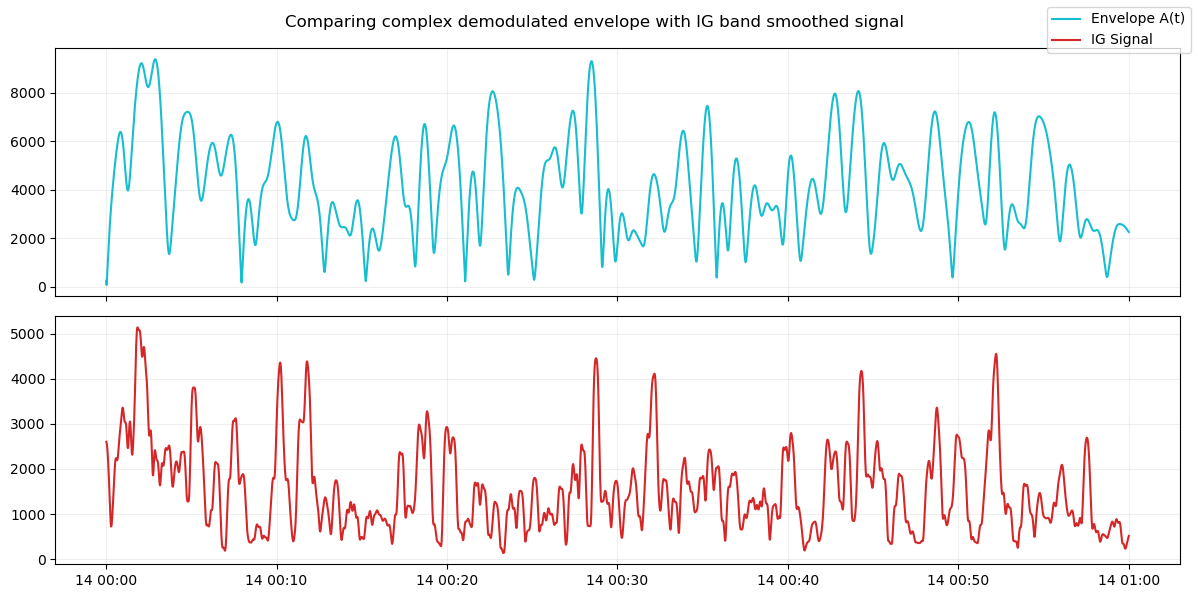

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert  # hilbert unused here, ok to drop

# ---- load data ----- #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

# ---- complex demod on one day of sensor 6 ---- #

# One day of hourly complex demod on sensor 6, using 'p'
out = complex_demod_hourly(df6, day="2008-01-14", p_col="p")

hour_example = list(out.keys())[0]
res = out[hour_example]


def bandpass_ig(x, fs, fmin=0.004, fmax=0.04):
    nyq = fs / 2
    b, a = butter(4, [fmin/nyq, fmax/nyq], btype="band")
    return filtfilt(b, a, x)

# ---- complex demod on one day of sensor 6 ---- #
out = complex_demod_hourly(df6, day="2008-01-14", p_col="p")
hour_example = list(out.keys())[0]
res = out[hour_example]

t_start, t_end = res["t"][0], res["t"][-1]           # or res["t"].min(), res["t"].max()
mask = (df6.index >= t_start) & (df6.index <= t_end)

eta_ig = bandpass_ig(df6["p"].values, fs=1.0)
eta_abs = np.abs(eta_ig)
eta_smooth = (
    pd.Series(eta_abs**2, index=df6.index)
      .rolling(20, center=True, min_periods=1)
      .mean()
      .pow(0.5)
)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax0.plot(res["t"], res["A"], label="Envelope A(t)", color="C9")
ax1.plot(eta_smooth.index[mask], eta_smooth[mask], label="IG Signal", color="C3")
ax0.grid(True, alpha=0.2); ax1.grid(True, alpha=0.2)
fig.suptitle('Comparing complex demodulated envelope with IG band smoothed signal')
fig.legend(); plt.tight_layout(); plt.show()



Want to find exact IG frequency that shows the envelope. So, going to do the following:
1. Compute spectra of A(t)
2. find the dominant low frequency $f_{mod}$
3.  Narrow band filter around $f_{mod}$
4. compare A(t) to narrowed IG signal

0.010833333333333334

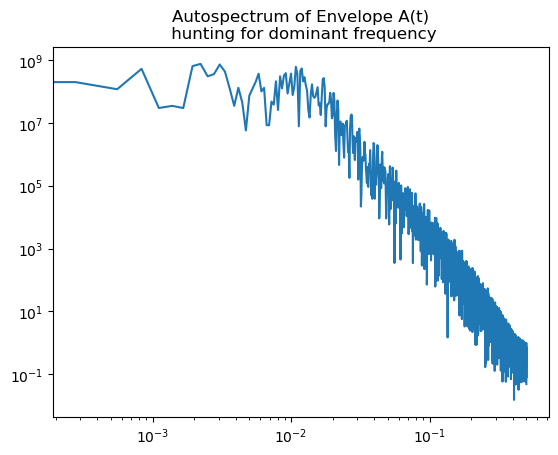

In [ ]:
 fA, tA, SA = spectrogram(
        res['A'], fs=fs, window='hann', nperseg=3600,
        noverlap=0.5*3600, detrend="linear",
        scaling="density", mode="psd"
    )

Pxx_avg = S.mean(axis=1)

# find peak in swell band
fmin, fmax = 0.004, 0.04
mask = (fA >= fmin) & (fA <= fmax)
fmod = fA[mask][np.argmax(Pxx_avg[mask])]

plt.loglog(fA, Pxx_avg)
plt.title('Autospectrum of Envelope A(t)\n hunting for dominant frequency')


In [85]:
from scipy.signal import welch
import numpy as np

fs = 1.0

# Detrend envelope a bit
A_d = res['A'] - np.mean(res['A'])

# Spectrum of the envelope
f_env, S_env = welch(A_d, fs=fs, nperseg=min(1024, len(A_d)))

# Look only in IG band
mask_ig = (f_env >= 0.004) & (f_env <= 0.04)

f_mod = f_env[mask_ig][np.argmax(S_env[mask_ig])]
print("Dominant modulation frequency f_mod =", f_mod, "Hz",
      "(period ~", 1.0/f_mod, "s)")


Dominant modulation frequency f_mod = 0.01171875 Hz (period ~ 85.33333333333333 s)


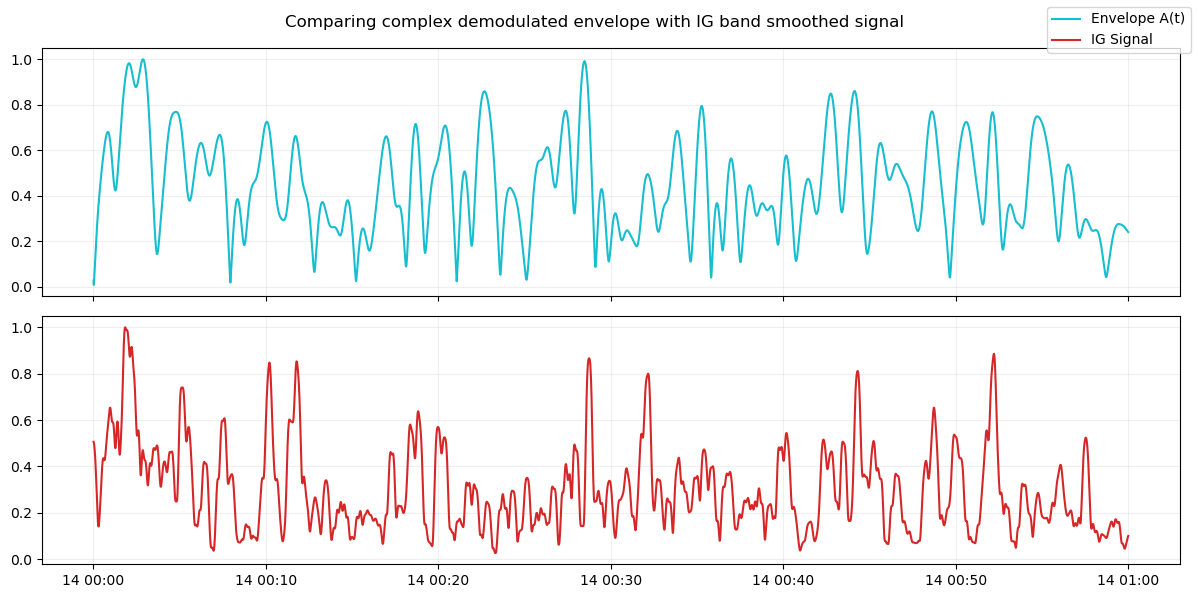

Correlation between A^2 and narrow-band IG = 0.42761868084275134


In [100]:
from scipy.signal import butter, filtfilt

def bandpass_narrow(x, fs, f_center, df=0.003):
    nyq = fs / 2
    fmin = max(0.001, f_center - df)
    fmax = min(0.049, f_center + df)
    b, a = butter(4, [fmin/nyq, fmax/nyq], btype="band")
    return filtfilt(b, a, x)

eta_ig_narrow = bandpass_narrow(p_hour, fs=fs, f_center=f_mod, df=0.003)
eta_abs = np.abs(eta_ig)

t_start, t_end = res["t"][0], res["t"][-1]           # or res["t"].min(), res["t"].max()
mask = (df6.index >= t_start) & (df6.index <= t_end)

eta_smooth = (
    pd.Series(eta_abs**2, index=df6.index)
      .rolling(20, center=True, min_periods=1)
      .mean()
      .pow(0.5)
)


fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax0.plot(res["t"], res["A"]/np.nanmax(res['A']), label="Envelope A(t)", color="C9")
ax1.plot(eta_smooth.index[mask], eta_smooth[mask]/np.nanmax(eta_smooth[mask]), label="IG Signal", color="C3")
ax0.grid(True, alpha=0.2); ax1.grid(True, alpha=0.2)
fig.suptitle('Comparing complex demodulated envelope with IG band smoothed signal')
fig.legend(); plt.tight_layout(); plt.show()

corr = pd.Series(res["A"]/np.nanmax(res['A']), index=t_hour).corr(pd.Series(eta_smooth[mask]/np.nanmax(eta_smooth[mask]), index=t_hour))
print("Correlation between A^2 and narrow-band IG =", corr)



#### IG vs setup

In [2]:
from src.bulk_parameters import Hs_band
from src.spectra import sensor_spectra
import pandas as pd
import numpy as np

# ---- load data ----- #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

#--- compute 6 hour spectral averages (following JB's writeup)---#
nperseg= 3600 * 6 # 6 hours
S1 = sensor_spectra(df1, nperseg=nperseg)
S6 = sensor_spectra(df6, nperseg=nperseg)

##------------- Compute Hs in IG band ---------------------

# time cutoff (exclude 1/17 and after to align sensor 1 and 6
TMAX = np.datetime64("2008-01-17")
S1t = S1.where(S1.time < TMAX, drop=True)
S6t = S6.where(S6.time < TMAX, drop=True)

IG = (0.004, 0.04)
Hig1 = Hs_band(S1, *IG)



In [3]:
from src.setup_tools import compute_setup

setup1 = compute_setup(S1, df1, band=(0.004, 0.04))
setup1.head()

/Users/isidorarojas/Desktop/DIRECTORY/2025/reef_runup/mokuleia/notebooks/../src/setup_tools.py:95: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  wl_avg = df_local[water_col].resample(avg_depth).mean()
/Users/isidorarojas/Desktop/DIRECTORY/2025/reef_runup/mokuleia/notebooks/../src/setup_tools.py:104: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  h_i_interp = wl_avg["h_avg_demean"].reindex(


,IG_Hs,eta_f,h_i,h_f,eta_i
time,,,,,
2007-12-14 15:00:01.047006207,0.214218,-0.000195,0.275665,1.834378,-1.558909
2007-12-14 18:00:01.094007807,0.198829,-0.000205,0.206106,1.502705,-1.296804
2007-12-14 21:00:01.141009407,0.180481,-0.000159,0.028410,1.598435,-1.570184
2007-12-15 00:00:01.188011007,0.166375,-0.000189,-0.104083,1.145665,-1.249937
2007-12-15 03:00:01.235012607,0.153946,-0.000145,-0.127038,1.275067,-1.402249


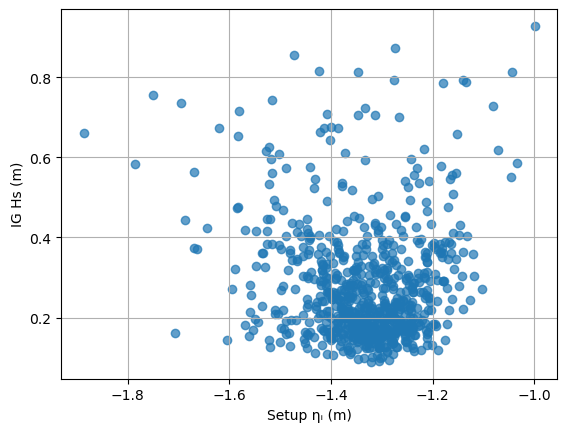

In [5]:
import matplotlib.pyplot as plt

plt.scatter(setup1["eta_i"], setup1["IG_Hs"], alpha=0.7)
plt.xlabel("Setup ηᵢ (m)")
plt.ylabel("IG Hs (m)")
plt.grid(True)
plt.show()


In [3]:
import pandas as pd
df6 = pd.read_parquet("../data_interim/df6.parquet")
df6['h'].mean()


11.921927629521868

In [ ]:
df6